### Import the keras package and [image preprocessing tools](https://keras.io/api/preprocessing/image/)


In [1]:
import keras
from keras.preprocessing.image import load_img, ImageDataGenerator, img_to_array, array_to_img

Using TensorFlow backend.


### Load a sample image and explore the shape

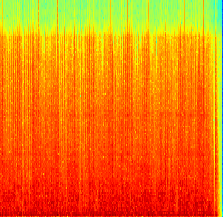

In [2]:
img = load_img("Ringo Starr - Better Days (Audio)--a5z6Wl7koE.png")
img

In [3]:
x = img_to_array(img)
print(x.shape)

(217, 223, 3)


In [4]:
x = x.reshape((1,) + x.shape)
print(x.shape)

(1, 217, 223, 3)


### Walk the artists' paths and get a list of dictionaries that contain the artist-album-song mapping. These dicts will be used to create a dataframe that we can use to extract all of the files using keras' ImageDataGenerator

In [5]:
import os
folders = ['Beatles', 'harrison', 'Lennon', 'mccartney', 'starr']

walk_gens = [os.walk(os.path.join(os.getcwd(), folder)) for folder in folders]

song_dicts =[]

for walk in walk_gens:
    for path, sub_folder, files in walk:
        dirname, folder_name = os.path.split(path) # check to get the plots folder
        dir2, album = os.path.split(dirname) # get the album name
        dir3, artist = os.path.split(dir2) # get the artist
        if folder_name == "plots":
            for song in files:
                song_dicts.append({"artist": artist,
                             "album": album,
                             "song": song})
                
                
            

In [7]:
# Create the dataframe
import pandas as pd

df = pd.DataFrame(song_dicts)
df

In [8]:
df.isnull().sum()

artist    0
album     0
song      0
dtype: int64

In [62]:
# split and the dataframe into our test set, which is all of the Beatle's albums, and shuffle rows as well
test_df = df[df["artist"] == "Beatles"].copy()
test_df = test_df.sample(frac=1)
test_df

,artist,album,song
50,Beatles,BeatlesForSale,Rock And Roll Music (Remastered 2009)-IRF6nmqc...
150,Beatles,SgtPepper,Good Morning Good Morning (Remastered 2009)-sj...
38,Beatles,AbbeyRoad,You Never Give Me Your Money (2019 Mix)-W8uZje...
147,Beatles,SgtPepper,Being For The Benefit Of Mr. Kite! (Remastered...
48,Beatles,BeatlesForSale,Mr Moonlight (Remastered 2009)-FZQ8nWZJrhA.png
...,...,...,...
210,Beatles,YellowSubmarine,Pepperland Laid Waste (Remastered 2009)-JGauvW...
142,Beatles,RubberSoul,Think For Yourself (Remastered 2009)-vtx5NTxeb...
66,Beatles,HardDaysNight,You Can't Do That (Remastered 2009)-6PK21u7Yzm...
166,Beatles,WhiteAlbum,Glass Onion (Remastered 2009)-2tSIZLuCKUI.png


In [10]:
train_df = df[~(df["artist"] == "Beatles")].copy()
train_df

,artist,album,song
216,harrison,AllMustPass,All Things Must Pass (2014 Mix)-it7mVLJaWIc.png
217,harrison,AllMustPass,Apple Scruffs (2014 Mix)-Bw-ky3BvAFI.png
218,harrison,AllMustPass,Art Of Dying (2014 Mix)-tmo8L7NlURQ.png
219,harrison,AllMustPass,Awaiting On You All (2014 Mix)-fbyHdlCVrRo.png
220,harrison,AllMustPass,Ballad Of Sir Frankie Crisp (Let It Roll)-B832...
...,...,...,...
962,starr,YNot,Ringo Starr - Mistery Of The Night-IwKD5iwsNx0...
963,starr,YNot,Ringo Starr - Peace Dream-rhVQqPx5Ubw.png
964,starr,YNot,Ringo Starr - Time-7MnC7zO8tk0.png
965,starr,YNot,Ringo Starr - Walk With You-tZ_5xlJ4KP4.png


In [65]:
train_df.loc[620, :]

artist                                         mccartney
album                                                New
song      Paul McCartney - Save Us (New)-0lZ4Ke9vTng.png
Name: 620, dtype: object

In [66]:
# shuffle the training files so the CNN model does not learn a pattern of the artists' images
train_df = train_df.sample(frac=1)

In [216]:
train_df.to_csv("train_df.csv", index=False)
test_df.to_csv("test_df.csv", index=False)

In [44]:
# list(train[["artist", "song"]].itertuples(index=False, name=None))

### Should have created all of the images in a train and test directory initially. In this step I will copy all of the immages to the proper train and test set directory for our ImageDataGenerator to use

In [13]:
import shutil

train = ['harrison', 'Lennon', 'mccartney', 'starr']
train_gens = [os.walk(os.path.join(os.getcwd(), folder)) for folder in train]
train_path = "C:\\Users\\Alec\\MyPython\\Beatles\\train"

In [50]:
for walk in train_gens:
    for path, sub_folder, files in walk:
        dirname, folder_name = os.path.split(path) # check to get the plots folder
        if folder_name == "plots":
            for song in files:
                song_path = os.path.join(path, song)
                shutil.copy(song_path, train_path)
                

In [14]:
test = ['Beatles']
test_gens = [os.walk(os.path.join(os.getcwd(), folder)) for folder in test]
test_path = "C:\\Users\\Alec\\MyPython\\Beatles\\test"

In [51]:
for walk in test_gens:
    for path, sub_folder, files in walk:
        dirname, folder_name = os.path.split(path) # check to get the plots folder
        if folder_name == "plots":
            for song in files:
                song_path = os.path.join(path, song)
                shutil.copy(song_path, test_path)

### Use the [Keras ImageDataGenerator](https://keras.io/api/preprocessing/image/#flowfromdataframe-method) to rescale the images.
### We will uses a use a 75% trainaing and 25% validation split, setting the batch_size to 20, and the image size to (256, 256)

In [76]:
batch_size = 20
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.25)

### Create the training and validation generators by using the training dataframe and training path

In [77]:
train_gen = datagen.flow_from_dataframe(dataframe=train_df,
                                        directory=train_path,
                                        x_col="song",
                                        y_col="artist",
                                        batch_size=batch_size,
                                        target_size=(256, 256),
                                        class_mode="categorical",
                                        shuffle=True,
                                        seed=1,
                                        subset="training",
                                        save_format="png"
                                       )

Found 564 validated image filenames belonging to 4 classes.


In [78]:
valid_gen = datagen.flow_from_dataframe(dataframe=train_df,
                                        directory=train_path,
                                        x_col="song",
                                        y_col="artist",
                                        batch_size=batch_size,
                                        target_size=(256, 256),
                                        class_mode="categorical",
                                        shuffle=True,
                                        seed=1,
                                        subset="validation",
                                        save_format="png"
                                       )

Found 187 validated image filenames belonging to 4 classes.


In [17]:
# Check if GPU is available
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2580506074312104485
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4930941747
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12928620297759751748
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


### Time to import the Keras layers to to create a Convolutional Newural Network to extract features of the spectrogram images

In [18]:
from keras.layers import Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense

In [79]:
model = keras.Sequential()
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(rate=0.3))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(rate=0.3))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))

In [80]:
model.add(GlobalAveragePooling2D())
model.build(input_shape=(None, 256, 256, 3))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 64, 64, 128)      

## Use the softmax activation function on the Dense layer to predict the probabilities of the classes 

In [81]:
model.add(Dense(4, activation='softmax'))
model.build(input_shape=(None, 256, 256, 3))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 64, 64, 128)      

### Use the Keras [Adam Optimizer](https://keras.io/api/optimizers/adam/) with the default parameters and the [Categorical Crossentropy loss function](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class) with the default parameters to compile the model. We will also have the model compute the accuracy of the training and validation sets

In [82]:
model.compile(keras.optimizers.Adam(), 
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

### Now to fit the model. Using 50 epochs to train the model

In [83]:
import numpy as np

steps_per_epoch = np.ceil(train_gen.samples/batch_size)
validation_steps = np.ceil(valid_gen.samples/batch_size)
history1 = model.fit_generator(train_gen,
                               validation_data=valid_gen,
                               epochs=50,
                               steps_per_epoch=steps_per_epoch,
                              validation_steps=validation_steps)

Epoch 1/50
29/29 [==============================] - 3s 101ms/step - loss: 1.3452 - accuracy: 0.3936 - val_loss: 1.3240 - val_accuracy: 0.3529
Epoch 2/50
29/29 [==============================] - 2s 82ms/step - loss: 1.3044 - accuracy: 0.4025 - val_loss: 1.2426 - val_accuracy: 0.3529
Epoch 3/50
29/29 [==============================] - 2s 82ms/step - loss: 1.2924 - accuracy: 0.4007 - val_loss: 1.4934 - val_accuracy: 0.3583
Epoch 4/50
29/29 [==============================] - 2s 82ms/step - loss: 1.2960 - accuracy: 0.4043 - val_loss: 1.2716 - val_accuracy: 0.3529
Epoch 5/50
29/29 [==============================] - 2s 82ms/step - loss: 1.3116 - accuracy: 0.4113 - val_loss: 1.2273 - val_accuracy: 0.3529
Epoch 6/50
29/29 [==============================] - 2s 82ms/step - loss: 1.2914 - accuracy: 0.4238 - val_loss: 1.3970 - val_accuracy: 0.4332
Epoch 7/50
29/29 [==============================] - 2s 82ms/step - loss: 1.2752 - accuracy: 0.4504 - val_loss: 1.2632 - val_accuracy: 0.4759
Epoch 8/50
2

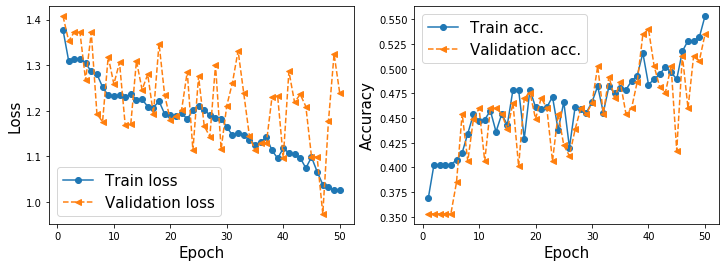

In [84]:
import matplotlib.pyplot as plt
hist1 = history1.history
x_arr = np.arange(len(hist['loss'])) + 1
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1,2,2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15),
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [86]:
model2 = keras.Sequential()
model2.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model2.add(MaxPooling2D(2,2))
model2.add(Dropout(rate=0.3))

model2.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model2.add(MaxPooling2D(2,2))
model2.add(Dropout(rate=0.3))

model2.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model2.add(MaxPooling2D(2,2))

model2.add(Conv2D(256, (3, 3), padding='same', activation='relu'))

model2.add(GlobalAveragePooling2D())

model2.add(Dense(4, activation='softmax'))
model2.build(input_shape=(None, 256, 256, 3))
model2.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 64, 64, 128)      

In [87]:
model2.compile(keras.optimizers.Adam(), 
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
history2 = model2.fit_generator(train_gen,
                               validation_data=valid_gen,
                               epochs=150,
                               steps_per_epoch=steps_per_epoch,
                              validation_steps=validation_steps)

Epoch 1/150
29/29 [==============================] - 3s 93ms/step - loss: 1.3361 - accuracy: 0.3670 - val_loss: 1.3463 - val_accuracy: 0.3529
Epoch 2/150
29/29 [==============================] - 2s 82ms/step - loss: 1.3151 - accuracy: 0.4025 - val_loss: 1.2671 - val_accuracy: 0.3529
Epoch 3/150
29/29 [==============================] - 2s 82ms/step - loss: 1.3042 - accuracy: 0.4025 - val_loss: 1.3397 - val_accuracy: 0.3529
Epoch 4/150
29/29 [==============================] - 2s 82ms/step - loss: 1.2894 - accuracy: 0.4025 - val_loss: 1.4394 - val_accuracy: 0.3529
Epoch 5/150
29/29 [==============================] - 2s 82ms/step - loss: 1.2646 - accuracy: 0.4025 - val_loss: 1.4438 - val_accuracy: 0.3636
Epoch 6/150
29/29 [==============================] - 2s 82ms/step - loss: 1.2675 - accuracy: 0.4131 - val_loss: 1.4160 - val_accuracy: 0.4545
Epoch 7/150
29/29 [==============================] - 2s 82ms/step - loss: 1.2600 - accuracy: 0.4415 - val_loss: 1.1733 - val_accuracy: 0.4385
Epoch 

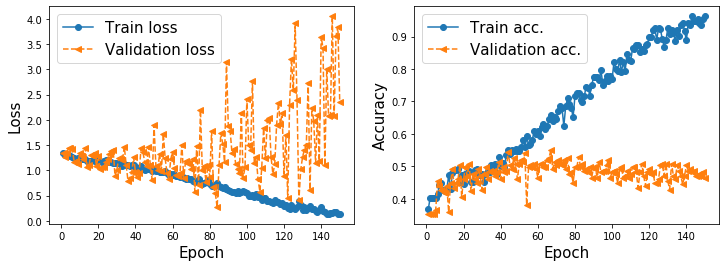

In [91]:
import matplotlib.pyplot as plt
hist2 = history2.history
x_arr = np.arange(len(hist2['loss'])) + 1
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr, hist2['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist2['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1,2,2)
ax.plot(x_arr, hist2['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist2['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15),
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [98]:
model3 = keras.Sequential()
model3.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model3.add(MaxPooling2D(2,2))
model3.add(Dropout(rate=0.3))

model3.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model3.add(MaxPooling2D(2,2))
model3.add(Dropout(rate=0.3))

model3.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model3.add(MaxPooling2D(2,2))

model3.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model3.add(MaxPooling2D(2,2))

model3.add(Conv2D(512, (3, 3), padding='same', activation='relu'))

model3.add(GlobalAveragePooling2D())

model3.add(Dense(4, activation='softmax'))
model3.build(input_shape=(None, 256, 256, 3))
model3.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 64, 64, 128)     

In [99]:
model3.compile(keras.optimizers.Adam(), 
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
history3 = model3.fit_generator(train_gen,
                               validation_data=valid_gen,
                               epochs=60,
                               steps_per_epoch=steps_per_epoch,
                              validation_steps=validation_steps)

Epoch 1/60
29/29 [==============================] - 3s 104ms/step - loss: 1.3572 - accuracy: 0.3989 - val_loss: 1.2944 - val_accuracy: 0.3529
Epoch 2/60
29/29 [==============================] - 3s 92ms/step - loss: 1.3022 - accuracy: 0.4025 - val_loss: 1.4438 - val_accuracy: 0.3529
Epoch 3/60
29/29 [==============================] - 3s 91ms/step - loss: 1.3119 - accuracy: 0.4025 - val_loss: 1.3457 - val_accuracy: 0.3529
Epoch 4/60
29/29 [==============================] - 3s 91ms/step - loss: 1.3198 - accuracy: 0.4025 - val_loss: 1.3465 - val_accuracy: 0.3529
Epoch 5/60
29/29 [==============================] - 3s 91ms/step - loss: 1.3012 - accuracy: 0.4025 - val_loss: 1.3068 - val_accuracy: 0.3529
Epoch 6/60
29/29 [==============================] - 3s 91ms/step - loss: 1.3029 - accuracy: 0.4025 - val_loss: 1.2035 - val_accuracy: 0.3529
Epoch 7/60
29/29 [==============================] - 3s 91ms/step - loss: 1.3064 - accuracy: 0.4025 - val_loss: 1.4035 - val_accuracy: 0.3529
Epoch 8/60
2

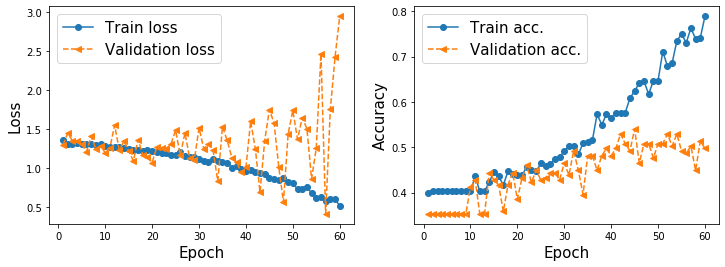

In [101]:
import matplotlib.pyplot as plt
hist3 = history3.history
x_arr = np.arange(len(hist3['loss'])) + 1
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr, hist3['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist3['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1,2,2)
ax.plot(x_arr, hist3['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist3['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15),
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [102]:
model4 = keras.Sequential()
model4.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model4.add(MaxPooling2D(2,2))
model4.add(Dropout(rate=0.3))

model4.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model4.add(MaxPooling2D(2,2))
model4.add(Dropout(rate=0.3))

model4.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model4.add(MaxPooling2D(2,2))

model4.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model4.add(MaxPooling2D(2,2))

model4.add(Conv2D(512, (3, 3), padding='same', activation='relu'))

model4.add(GlobalAveragePooling2D())

model4.add(Dense(4, activation='softmax'))
model4.build(input_shape=(None, 256, 256, 3))
model4.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 64, 64, 128)     

In [105]:
model4.compile(keras.optimizers.SGD(learning_rate=0.01), 
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
history4 = model4.fit_generator(train_gen,
                               validation_data=valid_gen,
                               epochs=50,
                               steps_per_epoch=steps_per_epoch,
                              validation_steps=validation_steps)

Epoch 1/50
29/29 [==============================] - 3s 99ms/step - loss: 1.2499 - accuracy: 0.4504 - val_loss: 1.3580 - val_accuracy: 0.4278
Epoch 2/50
29/29 [==============================] - 3s 91ms/step - loss: 1.2372 - accuracy: 0.4379 - val_loss: 1.1170 - val_accuracy: 0.4385
Epoch 3/50
29/29 [==============================] - 3s 92ms/step - loss: 1.2407 - accuracy: 0.4468 - val_loss: 1.3212 - val_accuracy: 0.4118
Epoch 4/50
29/29 [==============================] - 3s 91ms/step - loss: 1.2497 - accuracy: 0.4645 - val_loss: 1.5275 - val_accuracy: 0.4652
Epoch 5/50
29/29 [==============================] - 3s 92ms/step - loss: 1.2448 - accuracy: 0.4645 - val_loss: 1.2320 - val_accuracy: 0.4599
Epoch 6/50
29/29 [==============================] - 3s 92ms/step - loss: 1.2643 - accuracy: 0.4539 - val_loss: 1.2177 - val_accuracy: 0.4706
Epoch 7/50
29/29 [==============================] - 3s 92ms/step - loss: 1.2434 - accuracy: 0.4557 - val_loss: 1.3412 - val_accuracy: 0.4759
Epoch 8/50
29

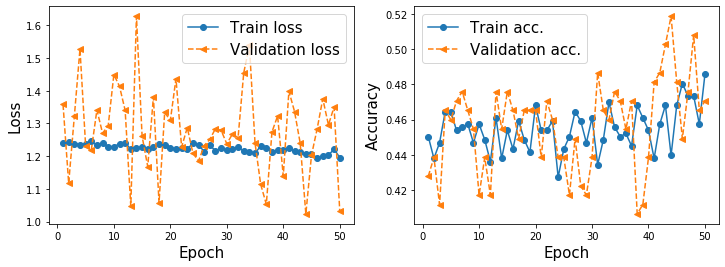

In [106]:
import matplotlib.pyplot as plt
hist4 = history4.history
x_arr = np.arange(len(hist4['loss'])) + 1
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr, hist4['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist4['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1,2,2)
ax.plot(x_arr, hist4['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist4['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15),
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [147]:
from keras.layers import TimeDistributed, LSTM, Flatten, Conv3D, MaxPooling3D
# model5 = keras.Sequential()
# model5.add(TimeDistributed(Conv2D(32, (2,2), padding='same', activation='relu'), input_shape=(None, 256, 256, 3)))
# model5.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
# model5.add(TimeDistributed(Dropout(rate=0.3)))

# model5.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
# model5.add(TimeDistributed(MaxPooling2D(2,2)))
# model5.add(TimeDistributed(Dropout(rate=0.3)))

# model5.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
# model5.add(TimeDistributed(MaxPooling2D(2,2)))

# model5.add(TimeDistributed(Conv2D(256, (3, 3), padding='same', activation='relu')))
# model5.add(TimeDistributed(MaxPooling2D(2,2)))

# model5.add(TimeDistributed(Flatten()))

# model5.add(LSTM(20))

# model5.add(Dense(4, activation='softmax'))
# model5.build(input_shape=(None, 256, 256, 3))
# model5.summary()

In [146]:
# model5.compile(keras.optimizers.Adam(), 
#               loss=keras.losses.CategoricalCrossentropy(),
#               metrics=['accuracy'])
# history5 = model5.fit_generator(train_gen,
#                                validation_data=valid_gen,
#                                epochs=50,
#                                steps_per_epoch=steps_per_epoch,
#                               validation_steps=validation_steps)

In [ ]:
# hist5 = history5.history
# x_arr = np.arange(len(hist5['loss'])) + 1
# fig = plt.figure(figsize=(12,4))
# ax = fig.add_subplot(1,2,1)
# ax.plot(x_arr, hist5['loss'], '-o', label='Train loss')
# ax.plot(x_arr, hist5['val_loss'], '--<', label='Validation loss')
# ax.legend(fontsize=15)
# ax.set_xlabel('Epoch', size=15)
# ax.set_ylabel('Loss', size=15)

# ax = fig.add_subplot(1,2,2)
# ax.plot(x_arr, hist5['accuracy'], '-o', label='Train acc.')
# ax.plot(x_arr, hist5['val_accuracy'], '--<', label='Validation acc.')
# ax.legend(fontsize=15)
# ax.set_xlabel('Epoch', size=15),
# ax.set_ylabel('Accuracy', size=15)
# plt.show()

In [135]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [155]:
model6 = keras.Sequential()
model6.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model6.add(MaxPooling2D(2,2))
model6.add(Dropout(rate=0.3))

model6.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model6.add(MaxPooling2D(2,2))
model6.add(Dropout(rate=0.3))

model6.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model6.add(MaxPooling2D(2,2))

model6.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model6.add(MaxPooling2D(2,2))
model6.add(Flatten())

model6.add(Dense(50))

model6.add(Dense(4, activation='softmax'))
model6.build(input_shape=(None, 256, 256, 3))
model6.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_122 (Conv2D)          (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_102 (MaxPoolin (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_63 (Dropout)         (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_103 (MaxPoolin (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_64 (Dropout)         (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_124 (Conv2D)          (None, 64, 64, 128)     

In [157]:
model6.compile(keras.optimizers.SGD(learning_rate=0.0001), 
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
history6 = model6.fit_generator(train_gen,
                               validation_data=valid_gen,
                               epochs=100,
                               steps_per_epoch=steps_per_epoch,
                              validation_steps=validation_steps)

Epoch 1/100
29/29 [==============================] - 3s 97ms/step - loss: 1.2765 - accuracy: 0.4113 - val_loss: 1.3471 - val_accuracy: 0.3690
Epoch 2/100
29/29 [==============================] - 2s 85ms/step - loss: 1.2864 - accuracy: 0.4220 - val_loss: 1.3464 - val_accuracy: 0.4011
Epoch 3/100
29/29 [==============================] - 2s 85ms/step - loss: 1.2813 - accuracy: 0.4096 - val_loss: 1.2850 - val_accuracy: 0.4011
Epoch 4/100
29/29 [==============================] - 2s 86ms/step - loss: 1.2932 - accuracy: 0.4273 - val_loss: 1.3663 - val_accuracy: 0.4011
Epoch 5/100
29/29 [==============================] - 2s 85ms/step - loss: 1.2918 - accuracy: 0.4184 - val_loss: 1.3246 - val_accuracy: 0.4118
Epoch 6/100
29/29 [==============================] - 2s 86ms/step - loss: 1.2834 - accuracy: 0.4113 - val_loss: 1.3890 - val_accuracy: 0.4011
Epoch 7/100
29/29 [==============================] - 2s 86ms/step - loss: 1.2910 - accuracy: 0.4362 - val_loss: 1.3611 - val_accuracy: 0.3690
Epoch 

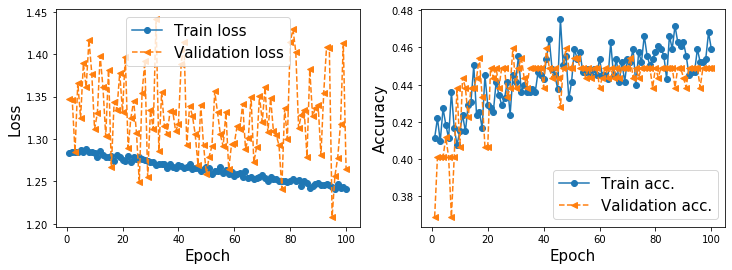

In [158]:
import matplotlib.pyplot as plt
hist6 = history6.history
x_arr = np.arange(len(hist6['loss'])) + 1
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr, hist6['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist6['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1,2,2)
ax.plot(x_arr, hist6['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist6['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15),
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [201]:
test_gen = datagen.flow_from_dataframe(dataframe=test_df,
                                        directory=test_path,
                                        x_col="song",
                                        y_col="artist",
                                        batch_size=batch_size,
                                        target_size=(256, 256),
                                        class_mode="categorical",
                                        shuffle=False,
                                        seed=1,
                                        save_format="png"
                                       )

Found 216 validated image filenames belonging to 1 classes.


In [160]:
x_batch, y_batch = next(test_gen)

In [163]:
x_batch[0].shape

(256, 256, 3)

C:\Users\Alec\anaconda3\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[1.]')

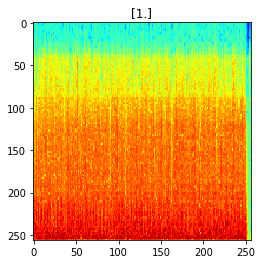

In [165]:
plt.imshow(x_batch[0])

In [166]:
y_batch[0]

array([1.], dtype=float32)

In [205]:
del preds

In [206]:
probabilities = model.predict_generator(test_gen)

In [207]:
probabilities.shape

(216, 4)

In [208]:
preds = np.argmax(probabilities, axis=1)

In [209]:
class_map = train_gen.class_indices

In [210]:
print(class_map)
print(first_batch_preds)

{'Lennon': 0, 'harrison': 1, 'mccartney': 2, 'starr': 3}
Series([], dtype: float64)


In [211]:
test_gen.filenames[:20]

['Rock And Roll Music (Remastered 2009)-IRF6nmqcbxo.png',
 'Good Morning Good Morning (Remastered 2009)-sjb9AxDkwAQ.png',
 'You Never Give Me Your Money (2019 Mix)-W8uZjeeOcQo.png',
 'Being For The Benefit Of Mr. Kite! (Remastered 2009)-bJVWZy4QOy0.png',
 'Mr Moonlight (Remastered 2009)-FZQ8nWZJrhA.png',
 'Carry That Weight (2019 Mix)-0RagyYjgY4g.png',
 'Dig A Pony (Remastered 2009)-LpdJE7HG8Ls.png',
 "Baby It's You (Remastered 2009)-AWUTlM6hz0g.png",
 "I'll Be Back (Remastered 2009)-fJSTBNTac6k.png",
 "Don't Bother Me (Remastered 2009)-k03IQbaTcxc.png",
 "I'll Cry Instead (Remastered 2009)-zfnkMBOSIUQ.png",
 "Octopus's Garden (2019 Mix)-x9VzJpl05N0.png",
 'Goodbye (Home Demo)-1EIcqz-sjy4.png',
 'The Beatles - Yellow Submarine-m2uTFF_3MaA.png',
 'The Ballad Of John And Yoko (Take 7)-hwzHeAnFqrk.png',
 'Nowhere Man (Remastered 2009)-8scSwaKbE64.png',
 'March Of The Meanies (Remastered 2009)-z2q5ailjVbA.png',
 'All My Loving (Remastered 2009)-TSpiwK5fig0.png',
 'The Long And Winding Road

In [212]:
pred_df = pd.DataFrame(data={"songs": test_gen.filenames,
                                   "predictions": preds})

In [193]:
mapping = {v:k for k,v in class_map.items()}

In [213]:
pred_df["predictions"] = pred_df["predictions"].map(mapping)

In [214]:
pred_df

,songs,predictions
0,Rock And Roll Music (Remastered 2009)-IRF6nmqc...,Lennon
1,Good Morning Good Morning (Remastered 2009)-sj...,Lennon
2,You Never Give Me Your Money (2019 Mix)-W8uZje...,starr
3,Being For The Benefit Of Mr. Kite! (Remastered...,Lennon
4,Mr Moonlight (Remastered 2009)-FZQ8nWZJrhA.png,Lennon
...,...,...
211,Pepperland Laid Waste (Remastered 2009)-JGauvW...,Lennon
212,Think For Yourself (Remastered 2009)-vtx5NTxeb...,Lennon
213,You Can't Do That (Remastered 2009)-6PK21u7Yzm...,Lennon
214,Glass Onion (Remastered 2009)-2tSIZLuCKUI.png,Lennon


In [215]:
pred_df.groupby("predictions").count()

,songs
predictions,
Lennon,162
mccartney,23
starr,31
